# Project 4 - Advanced Lane Finding

## Introduction

In this project, we apply advanced Computer Vision techniques to obtain more accurate and robust lane markings in images and video feeds.

---

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera calibration
The first step is to perform camera calibration, to obtain the camera calibration matrix and the distorsion coefficients.

### Extract chessboard corners

In [2]:
# Path to calibration images
calibration_images_paths = glob.glob('./camera_cal/*.jpg')

# Number of squares in X and Y direction
nx = 9
ny = 6

# Define object points for each image. We assume that each square
# has a size of 1 meter, and the origin is the top-left corner
# of the first square.
obj_pts_i = np.zeros((nx*ny, 3), np.float32)
obj_pts_i[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Declare obj and img points
obj_pts = []
img_pts = []

# Loop over images
for img_path in calibration_images_paths:
    # Read image
    img = cv2.imread(img_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find checkboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # Add points to list
        img_pts.append(corners)
        obj_pts.append(obj_pts_i)
    else:
        print('Warning: could not extract checkboard points from %s.' % img_path)

### Get calibration coefficients

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, gray.shape[::-1],None,None)

## Image undistortion

In [4]:
def undistort_img(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

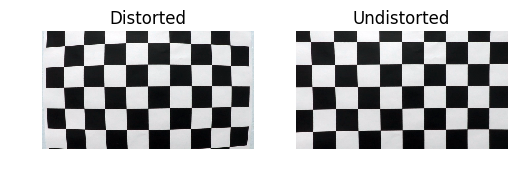

In [5]:
test_img = './camera_cal/calibration1.jpg'
img = cv2.imread(test_img)
plt.subplot(1,2,1);
plt.imshow(img);
plt.title('Distorted')
plt.axis('off');
plt.subplot(1,2,2);
plt.imshow(undistort_img(img));
plt.title('Undistorted')
plt.axis('off');

## Color masks

In [6]:
def mask_img(img, thresh):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

## Gradient masks

In [7]:
def compute_sobel(img, orient, sobel_kernel=3):
     # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        raise NotImplemented
    
    return sobel

def abs_sobel_mask(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Get sobel
    sobel = compute_sobel(img, orient)
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    return mask_img(scaled_sobel, thresh)
    
def mag_mask(img, sobel_kernel=3, thresh=(0, 255)):
    # Get sobel in X and Y directions
    sobel_x = compute_sobel(img, orient = 'x')
    sobel_y = compute_sobel(img, orient = 'y')
        
    # Take the absolute value of the derivative or gradient
    sobel_mag = np.sqrt(sobel_x * sobel_x + sobel_y * sobel_y)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    return mask_img(scaled_sobel, thresh)

def dir_mask(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Get sobel in X and Y directions
    sobel_x = compute_sobel(img, orient = 'x')
    sobel_y = compute_sobel(img, orient = 'y')
        
    # Calculate the absolute direction of the gradient 
    sobel_dir = np.absolute(np.arctan(sobel_y / (sobel_x + 1.e-7)))

    return mask_img(sobel_dir, thresh)

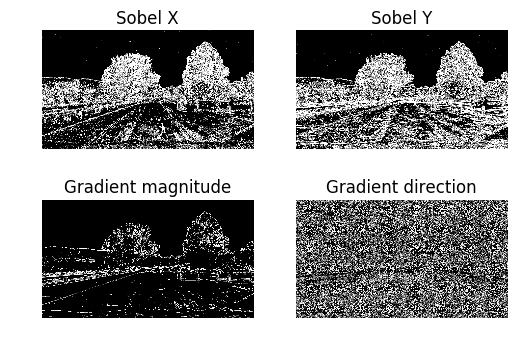

In [8]:
test_img = './test_images/test1.jpg'
img = cv2.imread(test_img)
plt.subplot(2,2,1);
plt.imshow(abs_sobel_mask(img, orient = 'x', thresh=(5,100)), cmap='gray');
plt.axis('off');
plt.title('Sobel X');
plt.subplot(2,2,2);
plt.imshow(abs_sobel_mask(img, orient = 'y', thresh=(5,100)), cmap='gray');
plt.axis('off');
plt.title('Sobel Y');
plt.subplot(2,2,3);
plt.imshow(mag_mask(img, thresh=(30,100)), cmap='gray');
plt.axis('off');
plt.title('Gradient magnitude');
plt.subplot(2,2,4);
plt.imshow(dir_mask(img, thresh=(0.7, 1.3)), cmap='gray');
plt.axis('off');
plt.title('Gradient direction');

## Combined mask

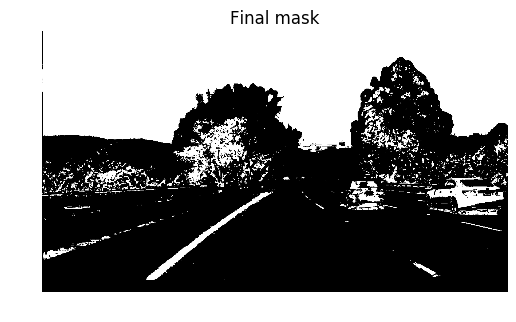

In [9]:
def combined_mask(img):
    # Convert to HLS
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # Color masks
    s_mask = mask_img(img_hls[:,:,2], (90, 255))
    # Gradient masks
    
    # Final mask
    mask = s_mask
    return s_mask

test_img = './test_images/test1.jpg'
img = cv2.imread(test_img)
plt.imshow(combined_mask(img), cmap='gray');
plt.axis('off');
plt.title('Final mask');

## Perspective transform

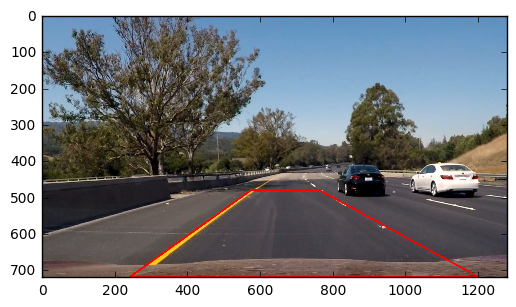

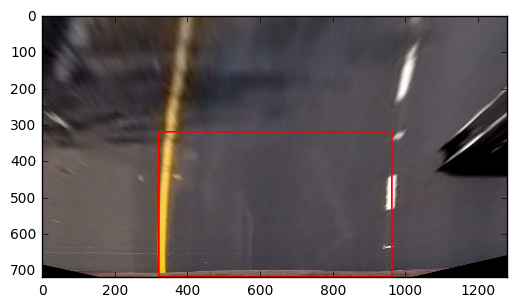

In [13]:
test_img = './test_images/test6.jpg'
img = mpimg.imread(test_img) 

src_pts_ = ((240, img.shape[0]),
           (1200, img.shape[0]),
           (760, int(img.shape[0]/1.5)),
           (575, int(img.shape[0]/1.5)))

offset = 320
dst_pts_ = ((offset,              img.shape[0]),
           (img.shape[1]-offset, img.shape[0]),
           (img.shape[1]-offset, offset),
           (offset,              offset))  


def get_birds_eye_view(img, src_pts=src_pts_, dst_pts=dst_pts_):
    img_size = (img.shape[1], img.shape[0])    
   
    M = cv2.getPerspectiveTransform(np.float32(src_pts), np.float32(dst_pts))
    
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)


img_pts = img.copy()
for i in range(4):
    img_pts = cv2.line(img_pts, src_pts_[i], src_pts_[(i+1)%4], color=[255,0,0], thickness=4)
    
    
img_warped = get_birds_eye_view(img)
for i in range(4):
    img_warped_pts = cv2.line(img_warped, dst_pts_[i], dst_pts_[(i+1)%4], color=[255,0,0], thickness=4)
    
plt.figure();
plt.imshow(img_pts);
plt.figure();
plt.imshow(img_warped_pts);

## Lane pixels detection

## Lane fitting

## Lane lines unwarping

## Visualization

## Complete pipeline

## Test on images

## Test on video